In [1]:
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
import os
from PIL import Image
# from transformers import CLIPProcessor, CLIPModel
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# # Initialize CLIP model and processor
# model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")


In [17]:
image_folder_path = "/scratch/$USER/yars_data/photos"

# # Load images and preprocess them
# embeddings = []
# for image_name in os.listdir(image_folder_path):
#     image_path = os.path.join(image_folder_path, image_name)
#     image = Image.open(image_path).convert("RGB")
#     inputs = processor(images=image, return_tensors="pt")
#     outputs = model.get_image_features(**inputs)
#     embeddings.append(outputs)

embeddings_tensor = torch.load("out/features.pt")[1:]

embeddings_numpy = embeddings_tensor.cpu().detach().numpy()

if len(embeddings_numpy.shape) > 2:
    embeddings_numpy = embeddings_numpy.reshape(embeddings_numpy.shape[0], -1)

In [18]:
# find optimal cluster amount - elbow method
distorsions = []
silhouette_avg = []
for k in range(2, 100):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings_numpy)
    distorsions.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(embeddings_numpy, kmeans.labels_))

In [29]:
import numpy as np
np.argmax(silhouette_avg[1:])
silhouette_avg[42]

0.03892115

Text(0.5, 1.0, 'Elbow curve')

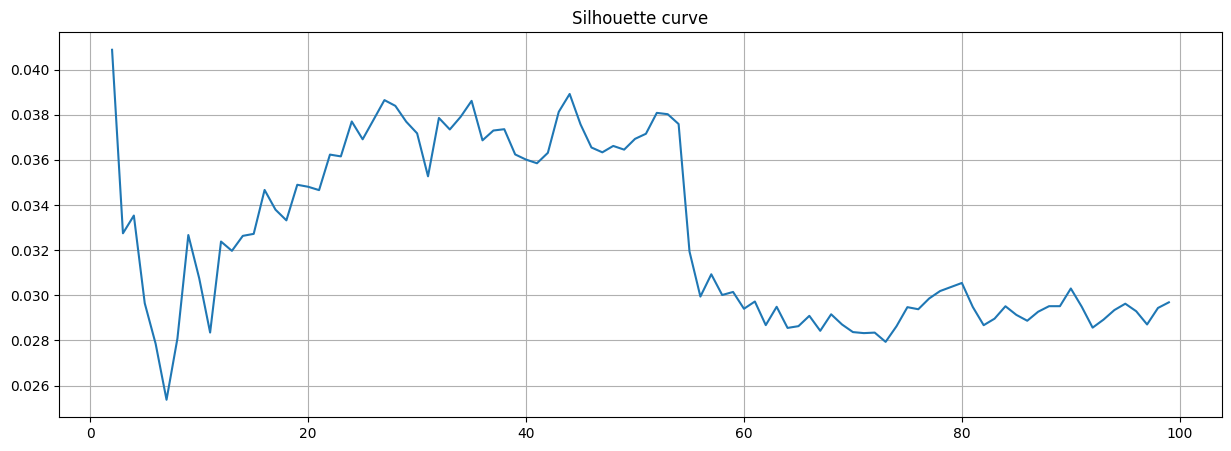

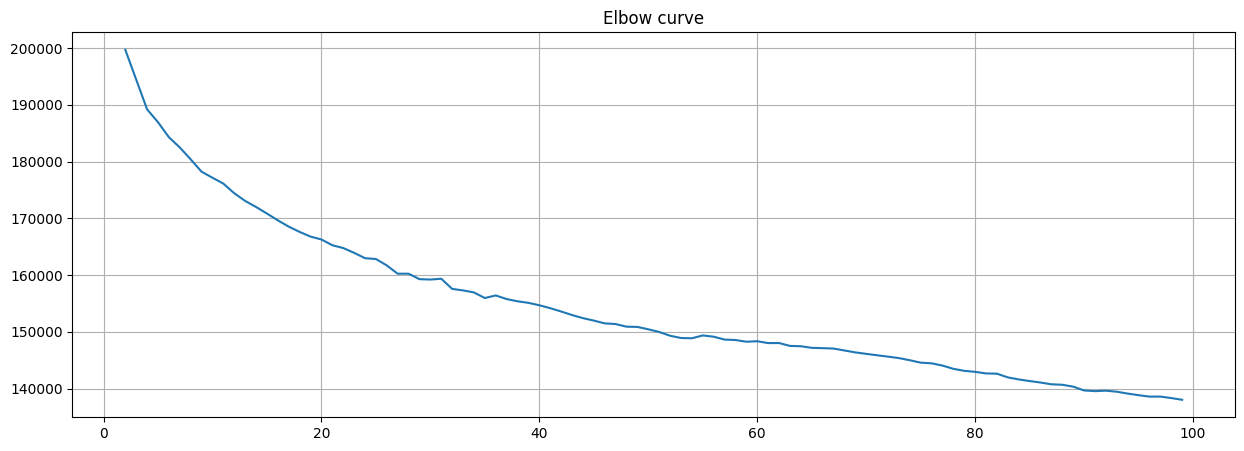

In [20]:
fig = plt.figure(figsize=(15, 5))
# plt.plot(range(2, 100), distorsions, label="elbow")
plt.plot(range(2, 100), silhouette_avg, label="silhouette")
plt.grid(True)
plt.title('Silhouette curve')

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 100), distorsions, label="elbow")
# plt.plot(range(2, 100), silhouette_avg, label="silhouette")
plt.grid(True)
plt.title('Elbow curve')

In [30]:
# 44 seems to be a good number
kmeans = KMeans(n_clusters=44, random_state=0).fit(embeddings_numpy)

In [51]:
paths  = open("out/paths.txt").read().split("\n")[1:]

cluster_images = {label: [] for label in range(kmeans.n_clusters)}

# Assign images to clusters
for idx, label in enumerate(kmeans.labels_):
    image_path = os.path.join(image_folder_path, paths[idx])
    cluster_images[label].append(image_path)


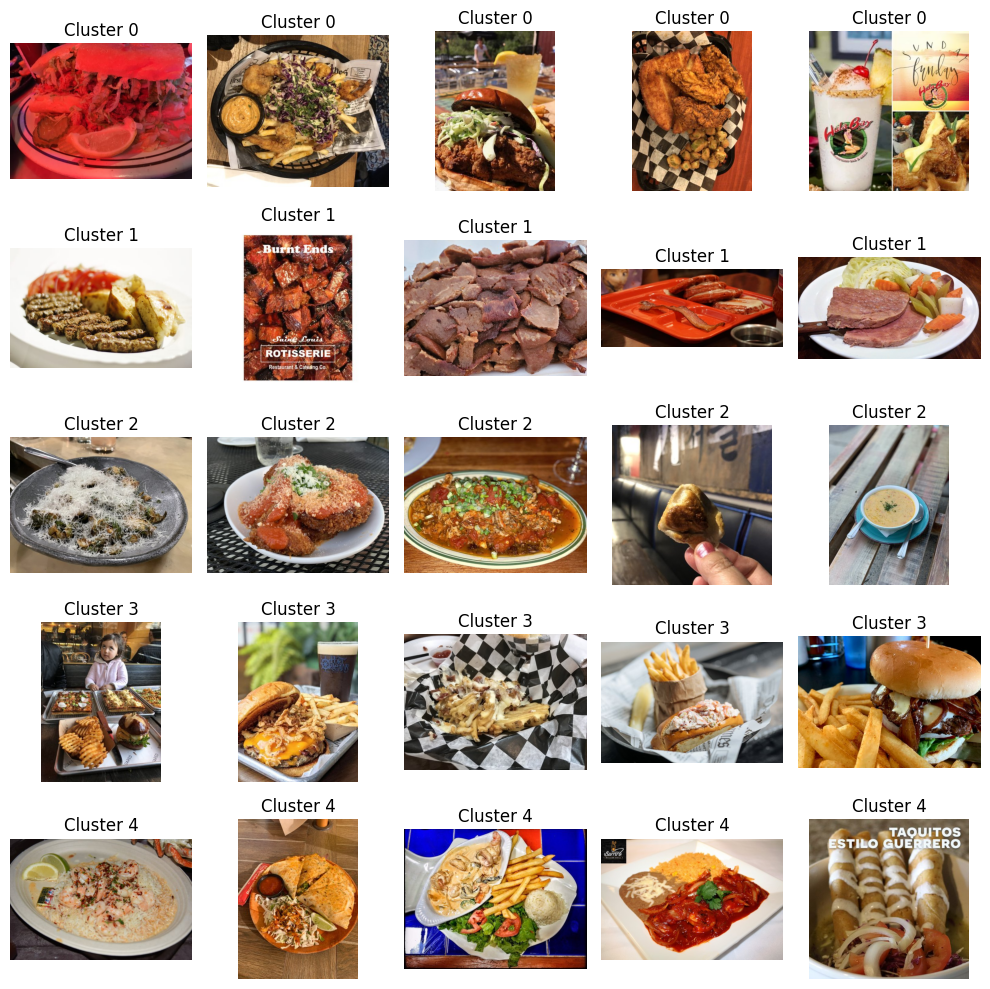

In [52]:
num_clusters = kmeans.n_clusters
clusters_to_show = 5
fig, axes = plt.subplots(nrows=clusters_to_show, ncols=5, figsize=(10, 2*clusters_to_show))
for cluster_num in range(num_clusters)[:clusters_to_show]:
    
    images_to_display = cluster_images[cluster_num][:5]

    for i, image_path in enumerate(images_to_display):
        img = Image.open(image_path)

        if num_clusters == 1:
            ax = axes[i]
        else:
            ax = axes[cluster_num, i]

        ax.imshow(img)
        ax.set_title(f'Cluster {cluster_num}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [36]:
from sklearn.cluster import DBSCAN

# eps is the maximum distance between two points for them to be considered as in the same neighborhood
# min_samples is the minimum number of points required to form a dense region, which DBSCAN considers as a cluster
# these need to be change for different dataset
dbscan = DBSCAN(eps=9, min_samples=2).fit(embeddings_numpy)

dbscan_labels = dbscan.labels_

num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found: {num_clusters}")

print(dbscan_labels)


Number of clusters found: 77
[-1 -1 -1 ... -1 -1 -1]


In [38]:
# Assign images to clusters (skip -1 label, noise)
cluster_images = {}
for idx, label in enumerate(dbscan_labels):
    if label != -1:
        if label not in cluster_images:
            cluster_images[label] = []
        cluster_images[label].append(paths[idx])


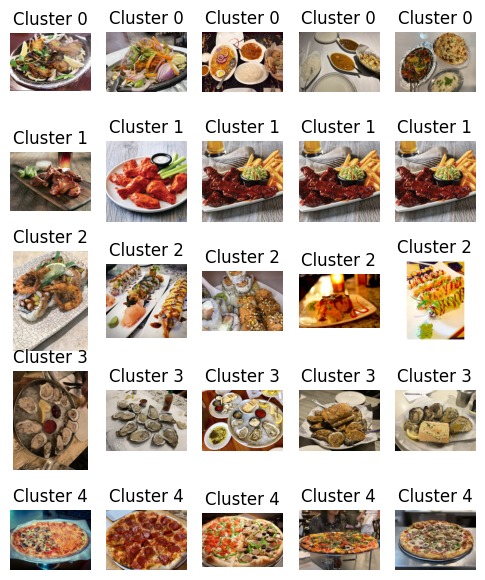

In [49]:
count = 0
fig, ax = plt.subplots(clusters_to_show, 5, figsize=(6, 1.5 * clusters_to_show))
for cluster, images in cluster_images.items():
        
    # more than one
    if len(images) >= 5:

        for i, image_name in enumerate(images[:5]):
            image_path = os.path.join(image_folder_path, image_name)
            image = Image.open(image_path)
            ax[count][i].imshow(image)
            ax[count][i].set_title(f'Cluster {count}')
            ax[count][i].axis('off')

        count += 1
        if count == clusters_to_show:
            break

plt.show()